In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import statsmodels.api as sm

sns.set_theme(rc={'figure.figsize':(10,6)})

## 1. Предварительный анализ и подготовка данных

In [2]:
transactions = pd.read_excel('./transactions_data.xlsx') # Датафрейм с которым будем работать

In [3]:
transactions_original = pd.read_excel('./transactions_data.xlsx') # Оригинальный датафрейм

In [4]:
transactions.head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer
3,524031ea-56e2-410a-aee2-e8fc6ae3fbc5,NaN,2025-03-02 03:14:10,Финансовое планирование,2313.980219,Неизвестно,Erichaven,Patricia Haas
4,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena


In [5]:
transactions.shape

(10000, 8)

In [6]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    9526 non-null   object 
 1   client_id         9798 non-null   object 
 2   transaction_date  10000 non-null  object 
 3   service           10000 non-null  object 
 4   amount            9540 non-null   float64
 5   payment_method    10000 non-null  object 
 6   city              10000 non-null  object 
 7   consultant        10000 non-null  object 
dtypes: float64(1), object(7)
memory usage: 625.1+ KB


***Замечаем что колонка transaction_date записана в виде строки, переведем ее в формат datetime64[ns]. <br>
Обычный парсинг даты выдает ошибку, посмотрим внимательнее на данные, чтобы понять в чем проблема.***

In [7]:
transactions['transaction_date'] = pd.to_datetime(
    transactions['transaction_date'],
    errors='coerce'  # Некорректные даты станут NaT (Not a Time)
)

In [8]:
transactions.isna().sum() # Видим что 1005 значений даты записаны в формате NaT

transaction_id       474
client_id            202
transaction_date    1005
service                0
amount               460
payment_method         0
city                   0
consultant             0
dtype: int64

In [9]:
transactions.query('transaction_date.isna() == True').head() # Найдем записи с некорректной датой

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant
17,125e15aa-1510-436d-b32f-79cc79bd2203,92c2cf71-fbc1-41aa-a88b-f2b702a7e946,NaT,Финансовое планирование,36818.406045,Наличные,Jeanettetown,Sarah Alvarez
18,bf0c08ab-c118-4155-91f4-95f09fe6a1fa,fedfe1eb-e79a-4527-9dd9-991af7e2b34d,NaT,Налоговое планирование,36896.308910,Кредитная карта,North Patrickport,Michelle Morse
25,190ce3c6-8657-437b-b3ba-1cc21dbbe421,53a3dcf3-3707-4fff-b1e1-ee2c4f357e1d,NaT,Управление активами,99420.587888,Наличные,Davidsonborough,Judith Hansen
29,e352563f-985f-46cb-9b1e-37ff7995b338,53113fae-453b-464b-8e39-a0337fc727e1,NaT,Инвестиционное консультирование,10711.465497,Банковский перевод,Cruzport,Ronald Benson
47,f88d0325-637c-4b0b-ad44-954aee483243,926eb57c-e1b9-41b2-a9e8-a3723563c505,NaT,Неизвестная услуга,2348.978021,Кредитная карта,Lake Tina,Kathryn Young


In [10]:
transactions_original.loc[17] # Строка 17 имеет значение transaction_date в виде строки INVALID_DATE

transaction_id      125e15aa-1510-436d-b32f-79cc79bd2203
client_id           92c2cf71-fbc1-41aa-a88b-f2b702a7e946
transaction_date                            INVALID_DATE
service                          Финансовое планирование
amount                                      36818.406045
payment_method                                  Наличные
city                                        Jeanettetown
consultant                                 Sarah Alvarez
Name: 17, dtype: object

***NaT значение получается там, где вместо времени указана строка INVALID_DATE***

In [11]:
transactions_original.query("transaction_date == 'INVALID_DATE'") # Все 1005 значений INVALID_DATE были преобразованы в формат NaT

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant
17,125e15aa-1510-436d-b32f-79cc79bd2203,92c2cf71-fbc1-41aa-a88b-f2b702a7e946,INVALID_DATE,Финансовое планирование,36818.406045,Наличные,Jeanettetown,Sarah Alvarez
18,bf0c08ab-c118-4155-91f4-95f09fe6a1fa,fedfe1eb-e79a-4527-9dd9-991af7e2b34d,INVALID_DATE,Налоговое планирование,36896.308910,Кредитная карта,North Patrickport,Michelle Morse
25,190ce3c6-8657-437b-b3ba-1cc21dbbe421,53a3dcf3-3707-4fff-b1e1-ee2c4f357e1d,INVALID_DATE,Управление активами,99420.587888,Наличные,Davidsonborough,Judith Hansen
29,e352563f-985f-46cb-9b1e-37ff7995b338,53113fae-453b-464b-8e39-a0337fc727e1,INVALID_DATE,Инвестиционное консультирование,10711.465497,Банковский перевод,Cruzport,Ronald Benson
47,f88d0325-637c-4b0b-ad44-954aee483243,926eb57c-e1b9-41b2-a9e8-a3723563c505,INVALID_DATE,Неизвестная услуга,2348.978021,Кредитная карта,Lake Tina,Kathryn Young
...,...,...,...,...,...,...,...,...
9963,8b8a2648-3982-4e13-8c5a-8d10e4129576,ed9c332f-d02a-411b-9414-9dec002b8821,INVALID_DATE,Управление активами,15904.945889,Банковский перевод,New Ryan,Mario Jones
9969,c186062d-b9e6-466c-abad-97a708fe90c3,fdee4854-6c12-47a0-a561-710264ce9d24,INVALID_DATE,Инвестиционное консультирование,79709.903415,Банковский перевод,Hamiltontown,Gregory Williams
9975,920abb78-41ac-442f-bf02-50398562022a,59859b6f-458d-4a72-88ee-48dba4e61574,INVALID_DATE,Инвестиционное консультирование,13579.842832,Кредитная карта,Patelbury,Judith Hansen
9977,d234eaa5-47c4-4221-9fcf-dac69c9a591a,041d30db-6572-46de-9a57-18b1c9f24034,INVALID_DATE,Управление активами,32927.948723,Банковский перевод,Michellehaven,Julie Jones


***Проверим все остальные пропущенные значения***

In [12]:
transactions.isna().sum() 

transaction_id       474
client_id            202
transaction_date    1005
service                0
amount               460
payment_method         0
city                   0
consultant             0
dtype: int64

In [13]:
transactions.query('transaction_id.isna() == True').head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant
11,NaN,740a1f26-a360-4ea2-974e-dbe5c3a3dd4e,2025-03-15 22:41:37,Управление активами,55780.022870,Банковский перевод,Ibarramouth,Phillip White
51,NaN,1b980cce-cdaf-4100-98d6-85cab0bab87c,NaT,Управление активами,89024.961022,Кредитная карта,East Melissaville,Gregory Williams
177,NaN,838e9c50-3158-4357-a9b3-7ce5403108ea,NaT,Инвестиционное консультирование,23286.852038,Кредитная карта,Bondstad,Melissa Pena
205,NaN,fe500414-9b79-4b96-951e-307963b5dbb3,NaT,Структурирование капитала,96836.510921,Кредитная карта,South Thomas,Kirsten Martin
295,NaN,74a945ec-3089-43f9-b324-6a63260c0aa0,2025-02-05 08:34:52,Финансовое планирование,95923.806806,Кредитная карта,North Emily,Jordan Phillips


In [14]:
transactions.query('client_id.isna() == True').head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant
3,524031ea-56e2-410a-aee2-e8fc6ae3fbc5,NaN,2025-03-02 03:14:10,Финансовое планирование,2313.980219,Неизвестно,Erichaven,Patricia Haas
21,0aed2448-4e41-4dfb-8de5-7a9e6f6d8d33,NaN,2025-01-27 18:27:54,Управление активами,110744.480002,Банковский перевод,New Ryan,Phillip White
60,0b83328f-0b7c-41ef-9427-aca57fc103e0,NaN,2025-01-03 16:52:49,Управление активами,14764.868857,Банковский перевод,Davidsonborough,Terry Brown
151,336709d3-87f0-422d-9185-29a553c3ced1,NaN,2025-01-11 20:32:04,Управление активами,79372.257155,Кредитная карта,East Rachelmouth,Timothy Brown
152,ec81ae99-2de7-465a-8885-6e9ebaaa24de,NaN,NaT,Управление активами,13413.262381,Кредитная карта,Cruzport,Sarah Alvarez


In [15]:
transactions.query('amount.isna() == True').head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant
31,8308ba05-750a-4b09-84a5-b4ea265d5b65,41d9d6b0-c17f-4b05-adda-e25e27528ccd,2025-01-10 13:06:07,Финансовое планирование,NaN,Банковский перевод,Elizabethmouth,Melissa Pena
53,e812de5c-6e78-4f53-8390-be7be2cd2b5e,46834f1c-6bfb-4c85-9ce5-9a32e02edd0e,2025-02-05 15:15:34,Структурирование капитала,NaN,Неизвестно,Matthewsville,Joshua Fuentes
79,85799cf0-7dd6-4542-8a93-8e49821c0bf8,a5962c1f-1541-4b73-b34d-a7b98f659c29,NaT,Финансовое планирование,NaN,Наличные,Trevinoberg,Ronald Benson
108,c94b4a73-db99-4656-9709-4f94db32310b,a0fcad49-94a4-4d38-b18e-9f3419cd7d2d,2025-01-25 21:07:04,Финансовое планирование,NaN,Неизвестно,New Chelseaberg,Jordan Phillips
112,cfe09808-b9fa-4908-9b3a-b232640793ac,54dafed5-4d51-4e19-b543-3ed0afe253bd,2025-01-09 17:23:13,Налоговое планирование,NaN,Кредитная карта,Cruzport,Alexandra Meyer


***Удаляем данные с пропущенными значениями***

In [16]:
transactions_df = transactions.dropna()
transactions_df.shape

(8012, 8)

In [17]:
transactions_df.isna().sum()

transaction_id      0
client_id           0
transaction_date    0
service             0
amount              0
payment_method      0
city                0
consultant          0
dtype: int64

In [18]:
transactions_df.duplicated().sum() # проверим наличие дубликатов

np.int64(0)

In [19]:
transactions_df.query('amount <= 0').amount.count() # проверим наличие отрицательных значений amount

np.int64(0)

In [20]:
transactions_df['date'] = pd.to_datetime(transactions_df.transaction_date.dt.date)

C:\Users\User\AppData\Local\Temp\ipykernel_16452\692057330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_df['date'] = pd.to_datetime(transactions_df.transaction_date.dt.date)


***Проверим остальные колонки на наличие пропущенных значений***

In [21]:
list(transactions_df.payment_method.unique()) # для payment_method есть неизвестные записи

['Банковский перевод',
 'Неизвестно',
 'Кредитная карта',
 'Криптовалюта',
 'Наличные']

In [22]:
transactions_df.query("payment_method == 'Неизвестно'") # 813 записей с payment_method == 'Неизвестно'

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,date
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard,2025-03-10
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer,2025-02-13
4,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena,2025-03-18
96,10a5703d-9020-46e0-89b2-40d979aa045c,eb356a59-d7be-48c3-ad9c-e0b804545c82,2025-01-24 06:53:45,Налоговое планирование,31403.717717,Неизвестно,North Hannahmouth,Mario Jones,2025-01-24
123,32009aa3-eabb-475a-95a5-8c2e3c85abd6,aa3ee6b5-7363-4b74-a389-c5039e699a3a,2025-01-04 11:36:28,Инвестиционное консультирование,42635.337304,Неизвестно,New Tommyborough,Teresa Baker,2025-01-04
...,...,...,...,...,...,...,...,...,...
9964,d039509d-fcef-4a4d-9ffc-eeb1626bc11d,569b0daf-0363-49f8-9aa1-3db692e3844f,2025-02-14 12:09:18,Налоговое планирование,30594.937411,Неизвестно,Port Jordan,Judith Hansen,2025-02-14
9976,07edee31-5148-4b89-a68d-e72bbe920426,e9ca611f-da18-44f6-80f3-7ef89b4916a2,2025-02-25 15:51:49,Налоговое планирование,54693.462820,Неизвестно,New Zacharyport,Kathryn Young,2025-02-25
9982,9d1a6ceb-92a3-4531-a627-6275ad0e039d,a54b78b1-2f9f-4d9c-a7d2-c4e092a4d4ab,2025-03-03 11:50:09,Инвестиционное консультирование,29364.858348,Неизвестно,Erichaven,Erik Garcia,2025-03-03
9994,c950f239-8404-43d1-ad3c-cf185483ac4f,602f63ba-3896-4462-8fb4-dd0921e5250b,2025-02-25 18:32:48,Инвестиционное консультирование,29445.814832,Неизвестно,New Dianechester,Catherine Lawson,2025-02-25


In [23]:
list(transactions_df.city.unique()) # для city есть неизвестные записи

['North Patrickport',
 'New Zacharyport',
 'Port Michellemouth',
 'Bondstad',
 'West Jaymouth',
 'Johnsonfort',
 'Tonystad',
 'Ronaldville',
 'Elizabethmouth',
 'Matthewsville',
 'North Lauriebury',
 'Lake Sallychester',
 'Trevinoberg',
 'South Andrew',
 'Hamiltontown',
 'Davidmouth',
 'New Dianechester',
 'Lake Arielmouth',
 'Lake Tina',
 'Krystalland',
 'Aprilstad',
 'South Thomas',
 'Erichaven',
 'North Hannahmouth',
 'Неизвестный город',
 'West Meredithhaven',
 'Cruzport',
 'North Melissaland',
 'New Ryan',
 'Patelbury',
 'Michellehaven',
 'Mayoberg',
 'Harrisberg',
 'Roberttown',
 'Dannyburgh',
 'East Melissaville',
 'Port Jordan',
 'North Emily',
 'Ibarramouth',
 'New Chelseaberg',
 'New Tommyborough',
 'East Matthewmouth',
 'East Jamie',
 'Karenville',
 'Kaneburgh',
 'Port James',
 'Mirandaside',
 'Jeanettetown',
 'East Rachelmouth',
 'Port Darlene',
 'Davidsonborough']

In [24]:
transactions_df.query("city == 'Неизвестный город'") # 315 записей с city == 'Неизвестный город'

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,date
42,fdf19748-ea94-47b6-9971-75e61cbbf934,9f24896c-8191-4b49-8922-6e27ce884c88,2025-02-10 03:38:40,Инвестиционное консультирование,46145.316416,Банковский перевод,Неизвестный город,Terry Brown,2025-02-10
44,e5a0992b-0394-44b1-bde7-0b52f9f65a88,4b09fb69-ed80-4b8b-9f2a-8aca21d61700,2025-03-15 18:50:54,Структурирование капитала,75231.150008,Наличные,Неизвестный город,Laura Herrera,2025-03-15
61,b14abe1c-48b5-4c97-b0d4-df533ac65b98,24df891c-d0ed-473d-9a4f-aa6a28aa45cb,2025-01-26 17:49:54,Неизвестная услуга,59536.473078,Банковский перевод,Неизвестный город,Travis Curtis,2025-01-26
84,c8095cd7-28b8-4029-ade0-6563582626ba,6ff42140-1978-4e5d-ba0a-b8aee5e82089,2025-02-03 16:29:17,Управление активами,34232.060797,Кредитная карта,Неизвестный город,Chad Raymond,2025-02-03
190,f9986723-cea3-46a4-ab98-556328458fdc,21e4715e-558f-4839-8086-8fa2fd7cb572,2025-01-15 20:23:18,Управление активами,4124.703523,Банковский перевод,Неизвестный город,Edwin Cantrell,2025-01-15
...,...,...,...,...,...,...,...,...,...
9883,6b4e602b-e69d-4410-a2fc-4abfb425f107,2a1f0d27-2d90-4f54-9311-7f67940356b7,2025-01-04 02:50:31,Управление активами,2861.469606,Кредитная карта,Неизвестный город,Alexandra Meyer,2025-01-04
9926,6ed864e5-c71b-416e-a593-cf67c3c1fd0e,b56ff432-c29b-4d3a-99ad-829568eac1c4,2025-02-15 02:03:04,Инвестиционное консультирование,40560.605167,Кредитная карта,Неизвестный город,Harold Gibson,2025-02-15
9956,0197a317-aaa5-4646-9dc8-01376e911f38,5bcbcb5e-e455-4533-ae4f-10eb661272fd,2025-02-18 18:31:01,Налоговое планирование,12967.900432,Кредитная карта,Неизвестный город,Jordan Phillips,2025-02-18
9978,93f8d1cb-d68f-4d69-a1d4-87e2e24d7760,e2ed52f8-cb45-4420-8fba-cdf0ecf39771,2025-01-09 22:31:45,Структурирование капитала,35587.483706,Банковский перевод,Неизвестный город,Timothy Brown,2025-01-09


In [25]:
list(transactions_df.consultant.unique()) # для consultant есть неизвестные записи

['Cheryl Waller',
 'Frank Pollard',
 'Alexandra Meyer',
 'Melissa Pena',
 'Harold Gibson',
 'Wendy Cooper',
 'Ethan Lowe',
 'Laura Herrera',
 'Ronald Shepherd',
 'Jordan Phillips',
 'Teresa Baker',
 'Gary Stevenson',
 'Неизвестный консультант',
 'Tiffany James',
 'Lisa Sanchez MD',
 'Erik Garcia',
 'David Thompson',
 'Emily Stewart',
 'Patricia Haas',
 'Travis Curtis',
 'Rachel Williamson',
 'Joshua Fuentes',
 'Chad Raymond',
 'Terry Brown',
 'Timothy Brown',
 'Kirsten Martin',
 'Mary Howard',
 'David Palmer',
 'Cynthia Coleman',
 'John Wolfe',
 'Phillip White',
 'Julie Jones',
 'Jason Beard',
 'Antonio Benton',
 'Sarah Alvarez',
 'Katherine Smith',
 'Stephen Jones',
 'Gregory Williams',
 'Michelle Morse',
 'Mario Jones',
 'Courtney Callahan',
 'Catherine Lawson',
 'William Bell',
 'Dylan Martin',
 'Nicholas Barry',
 'Edwin Cantrell',
 'Ronald Benson',
 'Kathryn Young',
 'Deborah Stone',
 'Judith Hansen',
 'Jessica Bates']

In [26]:
transactions_df.query("consultant == 'Неизвестный консультант'") # 280  записей с consultant == 'Неизвестный консультант'

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,date
15,11ad5e7b-5942-4d12-9a96-cff6f0facf79,4261949d-ee79-4d17-b9c2-0f4263864a83,2025-02-13 10:03:09,Структурирование капитала,64155.078900,Криптовалюта,North Lauriebury,Неизвестный консультант,2025-02-13
81,94cef9b2-385c-4ebf-81e5-0024793cfa30,30b6f45b-150f-43bc-be12-833d9a2b7ed7,2025-01-23 17:55:04,Неизвестная услуга,36227.604623,Криптовалюта,New Tommyborough,Неизвестный консультант,2025-01-23
87,4c751419-0a97-4478-81de-56f679721267,2b50e8ec-652e-4afd-b088-985ef3050e38,2025-01-13 14:24:44,Управление активами,37556.083562,Банковский перевод,Davidmouth,Неизвестный консультант,2025-01-13
113,bddf2296-0a3f-4990-818b-2e8cdd7c531e,a8a4df11-646e-414c-a7bc-8e40cdd0cd71,2025-01-16 03:23:02,Налоговое планирование,97862.942530,Кредитная карта,Port Michellemouth,Неизвестный консультант,2025-01-16
119,a76778be-5734-4dce-a24d-7eb1b1372c79,474b667c-823c-4ee0-9050-9505afc02e53,2025-01-24 07:32:15,Налоговое планирование,13683.281873,Кредитная карта,Davidmouth,Неизвестный консультант,2025-01-24
...,...,...,...,...,...,...,...,...,...
9756,3a5b4551-6bd7-4e3b-b91f-4b3134aebe8b,42dbe04e-0a3c-437d-89a0-7e430cf59361,2025-03-07 02:13:09,Неизвестная услуга,27730.256768,Кредитная карта,Port Darlene,Неизвестный консультант,2025-03-07
9780,29f0015c-aa4d-4c94-a3d3-478ebd2f5fe9,4ae62465-3349-478d-8237-f9b7bd915ffe,2025-01-21 10:34:47,Неизвестная услуга,31907.259898,Банковский перевод,Lake Sallychester,Неизвестный консультант,2025-01-21
9816,b4dc9a9a-e8d0-4484-bcf6-a11ee2a9e621,96f18880-219c-40f8-9da6-c0a78342c4f5,2025-01-15 14:50:23,Инвестиционное консультирование,31423.175226,Банковский перевод,Tonystad,Неизвестный консультант,2025-01-15
9929,8383f289-3e16-4e09-918f-4791090527a6,72483ebc-bbbc-4ed2-b231-9ced4e749c9c,2025-01-27 15:15:36,Структурирование капитала,59244.449634,Кредитная карта,Ibarramouth,Неизвестный консультант,2025-01-27


In [27]:
list(transactions_df.service.unique()) # для service есть неизвестные записи

['Структурирование капитала',
 'Инвестиционное консультирование',
 'Неизвестная услуга',
 'Налоговое планирование',
 'Управление активами',
 'Финансовое планирование']

In [28]:
transactions_df.query("service == 'Неизвестная услуга'") # 794 записей с service == 'Неизвестная услуга'

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,date
6,3f753dcc-d710-4640-bf88-085a52bd0a77,8c65a1e3-05a0-420d-800e-6ea786892ea1,2025-01-29 18:34:35,Неизвестная услуга,18383.907886,Кредитная карта,Johnsonfort,Wendy Cooper,2025-01-29
22,8436d6c3-b1b6-499e-bc08-84c10d22b615,d2c35d90-f102-4b9a-bff0-59d2008a6d6e,2025-01-28 04:32:05,Неизвестная услуга,49943.870517,Кредитная карта,Hamiltontown,Wendy Cooper,2025-01-28
30,b63f5c93-8fd7-4a79-ad92-e7eda3339975,bbd136c3-7f29-42e0-8abc-d8c4bb81fa69,2025-02-17 08:51:56,Неизвестная услуга,117442.413607,Кредитная карта,Lake Tina,David Thompson,2025-02-17
41,1ae9a1fd-c78a-4f35-b881-ba71d2385c68,c49af4d8-f101-4e6b-8c28-560179d19f66,2025-02-11 02:45:18,Неизвестная услуга,141881.371368,Кредитная карта,North Hannahmouth,Chad Raymond,2025-02-11
61,b14abe1c-48b5-4c97-b0d4-df533ac65b98,24df891c-d0ed-473d-9a4f-aa6a28aa45cb,2025-01-26 17:49:54,Неизвестная услуга,59536.473078,Банковский перевод,Неизвестный город,Travis Curtis,2025-01-26
...,...,...,...,...,...,...,...,...,...
9943,b43bda59-88b1-4abb-809b-27bf041529da,b5d63ea0-c6ee-481d-9f66-b991b58470d0,2025-01-05 15:10:08,Неизвестная услуга,18862.677797,Кредитная карта,North Melissaland,Michelle Morse,2025-01-05
9946,5809125d-9c0d-4f80-ade7-9b85ec64987b,8206c79f-4ac1-488e-aece-a4e91bffaa66,2025-01-18 12:29:32,Неизвестная услуга,71376.024806,Банковский перевод,East Rachelmouth,Nicholas Barry,2025-01-18
9966,0a811dc8-c062-4da1-a76a-f685df819d34,ef852271-2a7a-4c4b-b01f-a91b1117f5c7,2025-03-01 16:27:55,Неизвестная услуга,48511.661554,Банковский перевод,Kaneburgh,Tiffany James,2025-03-01
9984,b0fd15da-2775-4d20-bf67-ab306e907211,1a51a5a4-6998-41c2-b91d-f7e56016f9e1,2025-03-01 16:30:52,Неизвестная услуга,24825.820984,Банковский перевод,Erichaven,Mario Jones,2025-03-01


***Колонки service, consultant, city, payment_method имеют неизвестные значения. Удаление данных строк не желательно, так как приведет к потере большого массива данных, что может негативно сказаться на итогах анализа. Предлагается оставить строки с этими значениями в датасете в котором будем работать. Если нужно удалить строки с пропущенными значениями можно воспользоваться след. методом:***

In [29]:
transactions_df_cleared = transactions_df.query("service != 'Неизвестная услуга' & \
                                      consultant != 'Неизвестный консультант' & \
                                      city != 'Неизвестный город' & \
                                      payment_method != 'Неизвестно'")
transactions_df_cleared.head() # по итогу из изначального датафрейма было удалено почти 4000 тысячи строк с некорректными или неизвестными данными.

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,date
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller,2025-01-04
5,822d5795-4f08-4a7a-9692-7f5863945bdf,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,2025-02-21 21:50:30,Инвестиционное консультирование,85575.773285,Кредитная карта,West Jaymouth,Harold Gibson,2025-02-21
7,56daf0d6-6f65-45a2-8895-8bcbcf0a7f51,9f6d2dfb-20af-4329-8383-7bd7b14f2480,2025-03-11 22:56:28,Налоговое планирование,5590.175424,Банковский перевод,Tonystad,Ethan Lowe,2025-03-11
8,b40616d1-176c-4b07-9b7f-3f313440ccf6,27c2994f-97a1-4ff1-a9e4-bc52db0f603a,2025-01-06 19:54:19,Управление активами,84945.352622,Кредитная карта,Ronaldville,Laura Herrera,2025-01-06
9,5fcd81cd-379c-4dc7-a70e-f4ace842f3df,9f29e688-86ca-46f2-bfdd-0a9d33013f47,2025-01-27 17:59:07,Финансовое планирование,29785.105420,Криптовалюта,Elizabethmouth,Ronald Shepherd,2025-01-27


In [30]:
transactions_df.head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,date
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller,2025-01-04
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard,2025-03-10
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer,2025-02-13
4,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena,2025-03-18
5,822d5795-4f08-4a7a-9692-7f5863945bdf,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,2025-02-21 21:50:30,Инвестиционное консультирование,85575.773285,Кредитная карта,West Jaymouth,Harold Gibson,2025-02-21



***Вывод по главе: датасет был очищен и подготовлен к работе, были удалены строки с пропущенными данными, дата транзакции была преобразована в формат даты. </br>Итоговый размер датасета сократился до 8012 строк (было 10000)***


## 2. Анализ данных

***ВАЖНО! Продолжаем работу с датафреймом, в котором были удалены только строки, в которых неизвестные значения встречались в колоннках transaction_id, client_id, transaction_date, amount***

In [31]:
transactions_df.head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,date
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller,2025-01-04
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard,2025-03-10
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer,2025-02-13
4,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena,2025-03-18
5,822d5795-4f08-4a7a-9692-7f5863945bdf,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,2025-02-21 21:50:30,Инвестиционное консультирование,85575.773285,Кредитная карта,West Jaymouth,Harold Gibson,2025-02-21


***1. Определяем популярность услуг***

In [32]:
service_by_popularity = transactions_df \
                        .groupby('service') \
                        .agg({'transaction_id': 'count'}) \
                        .rename(columns={'transaction_id': 'transactions'}) \
                        .sort_values('transactions', ascending=False) \
                        .reset_index()
service_by_popularity

,service,transactions
0,Инвестиционное консультирование,1956
1,Управление активами,1606
2,Финансовое планирование,1242
3,Налоговое планирование,1218
4,Структурирование капитала,1196
5,Неизвестная услуга,794


In [33]:
transactions_df.service.value_counts()

service
Инвестиционное консультирование    1956
Управление активами                1606
Финансовое планирование            1242
Налоговое планирование             1218
Структурирование капитала          1196
Неизвестная услуга                  794
Name: count, dtype: int64

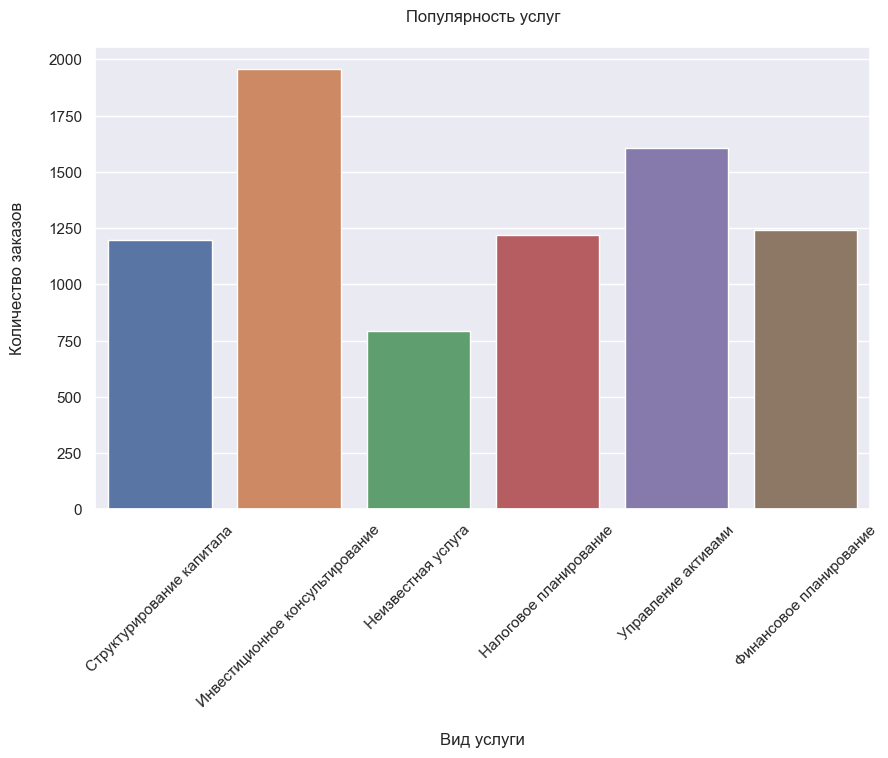

In [34]:
sns.countplot(transactions_df, x='service', hue='service')
plt.xticks(rotation=45)
plt.title("Популярность услуг\n")
plt.xlabel("\nВид услуги")
plt.ylabel("Количество заказов\n")
plt.show()

***ОТВЕТ: Самой популярной услугой является Инвестиционное консультирование***

***2. Определяем среднюю сумму транзакций по каждому городу***

In [35]:
avg_amount_by_city = \
transactions_df.groupby('city') \
               .agg({'amount': 'mean'}) \
               .rename(columns={'amount': 'avg_amount'}) \
               .sort_values('avg_amount', ascending=False) \
               .reset_index() \
               .round(2)
avg_amount_by_city.head()

,city,avg_amount
0,Michellehaven,58331.61
1,East Rachelmouth,57472.97
2,Port Michellemouth,57147.05
3,New Tommyborough,54873.15
4,North Lauriebury,54052.56


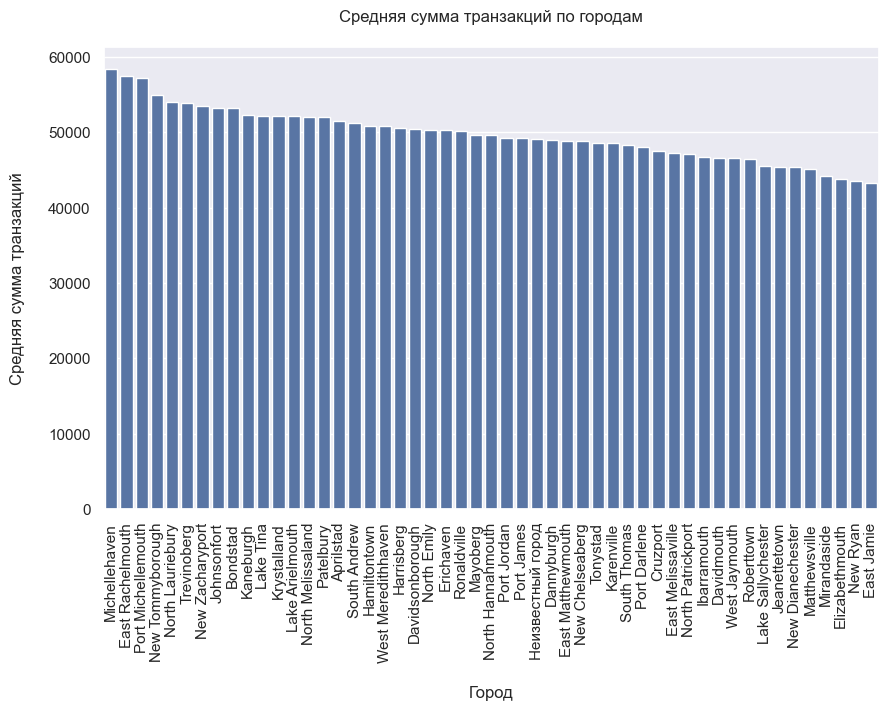

In [36]:
sns.barplot(avg_amount_by_city, x='city', y='avg_amount')
plt.xticks(rotation=90)
plt.title("Средняя сумма транзакций по городам\n")
plt.xlabel("\nГород")
plt.ylabel("Средняя сумма транзакций\n")
plt.show()

***3. Определяем услугу с наибольшей выручкой***

In [37]:
sum_amount_by_service = \
transactions_df.groupby('service') \
               .agg({'amount': 'sum'}) \
               .rename(columns={'amount': 'sum_amount'}) \
               .sort_values('sum_amount', ascending=False) \
               .reset_index() \
               .round(2)
sum_amount_by_service

,service,sum_amount
0,Инвестиционное консультирование,98211881.93
1,Управление активами,78942539.63
2,Финансовое планирование,62308065.67
3,Налоговое планирование,60469201.97
4,Структурирование капитала,57856337.57
5,Неизвестная услуга,40768382.17


***4. Вычисляем процент транзакций по способам оплаты***

In [38]:
payment_method_by_popularity = transactions_df \
                        .groupby('payment_method') \
                        .agg({'transaction_id': 'count'}) \
                        .rename(columns={'transaction_id': 'transactions'}) \
                        .sort_values('transactions', ascending=False) \
                        .reset_index()
payment_method_by_popularity

,payment_method,transactions
0,Кредитная карта,3208
1,Банковский перевод,2771
2,Неизвестно,813
3,Наличные,798
4,Криптовалюта,422


In [39]:
payment_method_by_popularity['pct'] = round(100 * payment_method_by_popularity.transactions / payment_method_by_popularity.transactions.sum(), 2)
payment_method_by_popularity

,payment_method,transactions,pct
0,Кредитная карта,3208,40.04
1,Банковский перевод,2771,34.59
2,Неизвестно,813,10.15
3,Наличные,798,9.96
4,Криптовалюта,422,5.27


***5. Рассчитаем выручку за последний месяц***

In [40]:
transactions_df.transaction_date.dt.to_period('M').max() # определим последний месяц в датасете

Period('2025-03', 'M')

In [41]:
transactions_df.transaction_date.describe()

count                             8012
mean     2025-02-09 08:24:23.456066048
min                2025-01-01 00:45:37
25%         2025-01-21 01:11:33.500000
50%                2025-02-09 07:00:56
75%      2025-02-28 15:18:17.750000128
max                2025-03-20 12:26:18
Name: transaction_date, dtype: object

In [42]:
last_month_transactions = transactions_df.query('transaction_date.dt.month == transaction_date.dt.month.max()') # отберем транзакции только за последний месяц
last_month_transactions

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,date
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard,2025-03-10
4,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena,2025-03-18
7,56daf0d6-6f65-45a2-8895-8bcbcf0a7f51,9f6d2dfb-20af-4329-8383-7bd7b14f2480,2025-03-11 22:56:28,Налоговое планирование,5590.175424,Банковский перевод,Tonystad,Ethan Lowe,2025-03-11
10,e5f0b30c-322d-448e-9bfe-152a8d15c943,d88d56e9-5b1c-4d9e-8453-5ec594f38eed,2025-03-08 01:20:51,Управление активами,3193.128156,Кредитная карта,Johnsonfort,Jordan Phillips,2025-03-08
16,c2a16f1a-125f-4cb7-8307-5ecc080b4123,2d75aeca-1211-479a-a190-6af66c85f3d8,2025-03-08 20:34:06,Инвестиционное консультирование,120835.547581,Банковский перевод,Lake Sallychester,Tiffany James,2025-03-08
...,...,...,...,...,...,...,...,...,...
9982,9d1a6ceb-92a3-4531-a627-6275ad0e039d,a54b78b1-2f9f-4d9c-a7d2-c4e092a4d4ab,2025-03-03 11:50:09,Инвестиционное консультирование,29364.858348,Неизвестно,Erichaven,Erik Garcia,2025-03-03
9984,b0fd15da-2775-4d20-bf67-ab306e907211,1a51a5a4-6998-41c2-b91d-f7e56016f9e1,2025-03-01 16:30:52,Неизвестная услуга,24825.820984,Банковский перевод,Erichaven,Mario Jones,2025-03-01
9990,7a8332be-7c53-4092-ac97-840a859e804c,435fa3f3-0196-4ff3-b6ec-223a0495e093,2025-03-09 13:37:01,Налоговое планирование,6410.891951,Кредитная карта,Неизвестный город,Catherine Lawson,2025-03-09
9991,7d35d69f-8b66-4fac-827c-e7bf48946c19,4c39038a-2332-4725-bb53-37add6f3f934,2025-03-08 09:44:55,Управление активами,4636.558233,Банковский перевод,Cruzport,Deborah Stone,2025-03-08


In [43]:
last_month_transactions.amount.sum().round(2) # посчитаем выручку

np.float64(98944989.3)

***Ответ: выручка за последний месяц равна 98 944 989.3***

***Вывод по главе: была определена популярность услуг, средняя сумма транзакций по каждому городу, определена услуга с наибольшей выручкой, вычислен процент транзакций по способам оплаты, рассчитана выручка за последний месяц. Были построены соответствующие диаграммы.***

## 3. Объединение данных

***1. Предобработка клиентских данных***

In [44]:
clients_data = pd.read_json('./clients_data.json') 

In [45]:
clients_data.head()

,id,age,gender,net_worth
0,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,41.0,Мужчина,2514729.46
1,c940f45c-d29b-439a-8fa3-f75018cef528,28.0,Мужчина,566568.29
2,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,55.0,Женщина,1896001.28
3,None,38.0,Женщина,4538759.60
4,3f43d7bc-37f0-4535-8391-51702d6ff81e,31.0,Мужчина,4865849.92


In [46]:
clients_data.shape

(9799, 4)

In [47]:
clients_data.isna().sum() # поиск пропущенных значений

id              1
age           983
gender       3319
net_worth     475
dtype: int64

In [48]:
clients_data.dropna(subset=['id', 'net_worth'], inplace=True) # Удаление пропущенных значений
clients_data.head()

,id,age,gender,net_worth
0,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,41.0,Мужчина,2514729.46
1,c940f45c-d29b-439a-8fa3-f75018cef528,28.0,Мужчина,566568.29
2,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,55.0,Женщина,1896001.28
4,3f43d7bc-37f0-4535-8391-51702d6ff81e,31.0,Мужчина,4865849.92
5,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,59.0,Женщина,3992281.84


In [49]:
transactions_df.head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,date
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller,2025-01-04
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard,2025-03-10
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer,2025-02-13
4,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena,2025-03-18
5,822d5795-4f08-4a7a-9692-7f5863945bdf,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,2025-02-21 21:50:30,Инвестиционное консультирование,85575.773285,Кредитная карта,West Jaymouth,Harold Gibson,2025-02-21


***2. Объединение клиентских данных и данных о транзакциях***

In [50]:
clients_transactions = pd.merge(transactions_df, clients_data, left_on='client_id', right_on='id', how='left').drop(columns=['id'])
clients_transactions

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,date,age,gender,net_worth
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller,2025-01-04,41.0,Мужчина,2514729.46
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard,2025-03-10,28.0,Мужчина,566568.29
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer,2025-02-13,55.0,Женщина,1896001.28
3,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena,2025-03-18,31.0,Мужчина,4865849.92
4,822d5795-4f08-4a7a-9692-7f5863945bdf,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,2025-02-21 21:50:30,Инвестиционное консультирование,85575.773285,Кредитная карта,West Jaymouth,Harold Gibson,2025-02-21,59.0,Женщина,3992281.84
...,...,...,...,...,...,...,...,...,...,...,...,...
8007,c950f239-8404-43d1-ad3c-cf185483ac4f,602f63ba-3896-4462-8fb4-dd0921e5250b,2025-02-25 18:32:48,Инвестиционное консультирование,29445.814832,Неизвестно,New Dianechester,Catherine Lawson,2025-02-25,43.0,Женщина,2549833.32
8008,8c90fcca-6a86-4126-a645-62f0f00e09ff,b79d6e9f-75f6-4af9-8fdf-b42aac298a84,2025-01-14 05:07:17,Налоговое планирование,117114.096418,Неизвестно,South Thomas,John Wolfe,2025-01-14,33.0,Женщина,699254.80
8009,03532e95-60c2-45ff-a731-3651d596989d,5e1d67fb-26ea-48cc-9e2d-e2edbda404d0,2025-02-09 17:33:42,Неизвестная услуга,79279.034410,Банковский перевод,Lake Arielmouth,Mary Howard,2025-02-09,49.0,None,3865097.90
8010,f5df7e5e-5e5e-4492-afc7-98040ff89dde,77ea6e72-df3c-47d4-a043-f990cc05a6f4,2025-01-21 03:54:39,Инвестиционное консультирование,26365.015457,Криптовалюта,Tonystad,David Palmer,2025-01-21,33.0,Женщина,4873134.42


In [51]:
clients_transactions.isna().sum()

transaction_id         0
client_id              0
transaction_date       0
service                0
amount                 0
payment_method         0
city                   0
consultant             0
date                   0
age                 1195
gender              2963
net_worth            391
dtype: int64

In [52]:
clients_transactions.dropna(subset=['net_worth'], inplace=True) # удаляем строки в которых нет информации о net_worth
clients_transactions.isna().sum()

transaction_id         0
client_id              0
transaction_date       0
service                0
amount                 0
payment_method         0
city                   0
consultant             0
date                   0
age                  804
gender              2572
net_worth              0
dtype: int64

***3. Создаем функцию для добавления колоннки с информацией об уровне активов клиентов***

In [53]:
def get_net_worth_lvl(net_worth):
    if net_worth < 100000:
        return 'low_capital'
    elif 100000 <= net_worth <= 1000000:
        return 'medium_capital'
    else:
        return 'high_capital'

In [54]:
clients_transactions['client_capital_lvl'] = clients_transactions.net_worth.apply(get_net_worth_lvl)

In [55]:
clients_transactions

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,date,age,gender,net_worth,client_capital_lvl
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller,2025-01-04,41.0,Мужчина,2514729.46,high_capital
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard,2025-03-10,28.0,Мужчина,566568.29,medium_capital
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer,2025-02-13,55.0,Женщина,1896001.28,high_capital
3,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena,2025-03-18,31.0,Мужчина,4865849.92,high_capital
4,822d5795-4f08-4a7a-9692-7f5863945bdf,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,2025-02-21 21:50:30,Инвестиционное консультирование,85575.773285,Кредитная карта,West Jaymouth,Harold Gibson,2025-02-21,59.0,Женщина,3992281.84,high_capital
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8007,c950f239-8404-43d1-ad3c-cf185483ac4f,602f63ba-3896-4462-8fb4-dd0921e5250b,2025-02-25 18:32:48,Инвестиционное консультирование,29445.814832,Неизвестно,New Dianechester,Catherine Lawson,2025-02-25,43.0,Женщина,2549833.32,high_capital
8008,8c90fcca-6a86-4126-a645-62f0f00e09ff,b79d6e9f-75f6-4af9-8fdf-b42aac298a84,2025-01-14 05:07:17,Налоговое планирование,117114.096418,Неизвестно,South Thomas,John Wolfe,2025-01-14,33.0,Женщина,699254.80,medium_capital
8009,03532e95-60c2-45ff-a731-3651d596989d,5e1d67fb-26ea-48cc-9e2d-e2edbda404d0,2025-02-09 17:33:42,Неизвестная услуга,79279.034410,Банковский перевод,Lake Arielmouth,Mary Howard,2025-02-09,49.0,None,3865097.90,high_capital
8010,f5df7e5e-5e5e-4492-afc7-98040ff89dde,77ea6e72-df3c-47d4-a043-f990cc05a6f4,2025-01-21 03:54:39,Инвестиционное консультирование,26365.015457,Криптовалюта,Tonystad,David Palmer,2025-01-21,33.0,Женщина,4873134.42,high_capital


In [56]:
client_lvl_data = clients_transactions.groupby('client_capital_lvl').amount.agg(['mean', 'median', 'sum', 'count']).reset_index().round() # вычислим необходимые данные по группам
client_lvl_data

,client_capital_lvl,mean,median,sum,count
0,high_capital,49795.0,42275.0,305638651.0,6138
1,low_capital,47650.0,43405.0,6813887.0,143
2,medium_capital,48800.0,41580.0,65392167.0,1340


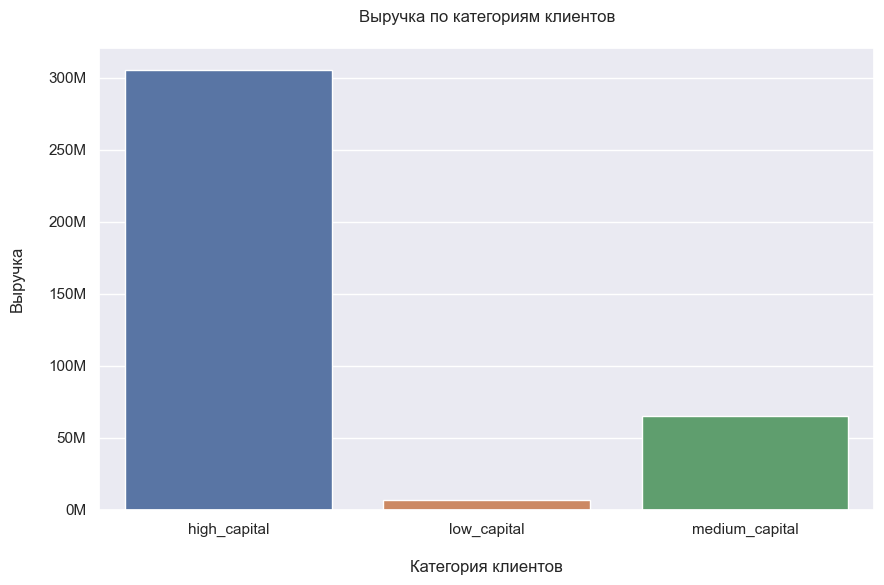

In [57]:
sns.barplot(client_lvl_data, y='sum', x='client_capital_lvl', hue='client_capital_lvl')
plt.title("Выручка по категориям клиентов\n")
plt.xlabel("\nКатегория клиентов")
plt.ylabel("Выручка\n")

def format_ticks(value, _):
    return f"{value / 1_000_000:.0f}M"
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.show()

***Ответ: наибольшую прибыль приносят клиенты группы high_capital (высокий капитал)***

***Вывод по главе: данные были предобработаны и объединены в один датасет. Была вычислена выручка по категориям клиентов***

## 4. Визуализация данных

***1. Построим график распределения сумм транзакций***

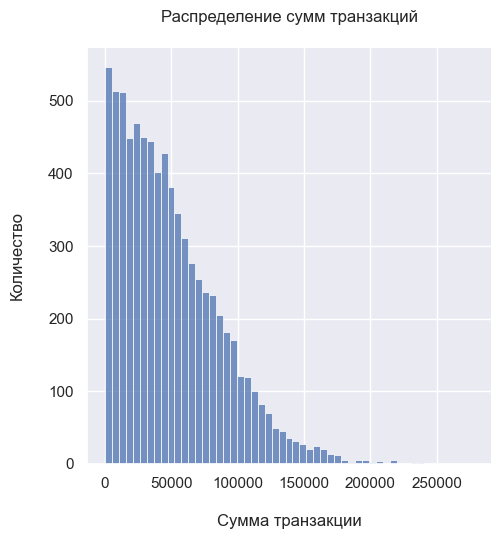

In [58]:
sns.displot(clients_transactions.amount)
plt.title("Распределение сумм транзакций\n")
plt.xlabel("\nСумма транзакции")
plt.ylabel("Количество\n")
plt.show()

***Ответ: распределение не является нормальным, количество транзакций убывает по мере увеличения суммы транзакции***

***2. Построим диаграмму выручки по услугам***

In [59]:
clients_transactions.head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,date,age,gender,net_worth,client_capital_lvl
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller,2025-01-04,41.0,Мужчина,2514729.46,high_capital
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard,2025-03-10,28.0,Мужчина,566568.29,medium_capital
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer,2025-02-13,55.0,Женщина,1896001.28,high_capital
3,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena,2025-03-18,31.0,Мужчина,4865849.92,high_capital
4,822d5795-4f08-4a7a-9692-7f5863945bdf,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,2025-02-21 21:50:30,Инвестиционное консультирование,85575.773285,Кредитная карта,West Jaymouth,Harold Gibson,2025-02-21,59.0,Женщина,3992281.84,high_capital


In [60]:
amount_by_service = clients_transactions.groupby('service', as_index=False).amount.sum().round()
amount_by_service

,service,amount
0,Инвестиционное консультирование,92953794.0
1,Налоговое планирование,57605259.0
2,Неизвестная услуга,39667352.0
3,Структурирование капитала,54672789.0
4,Управление активами,74012678.0
5,Финансовое планирование,58932833.0


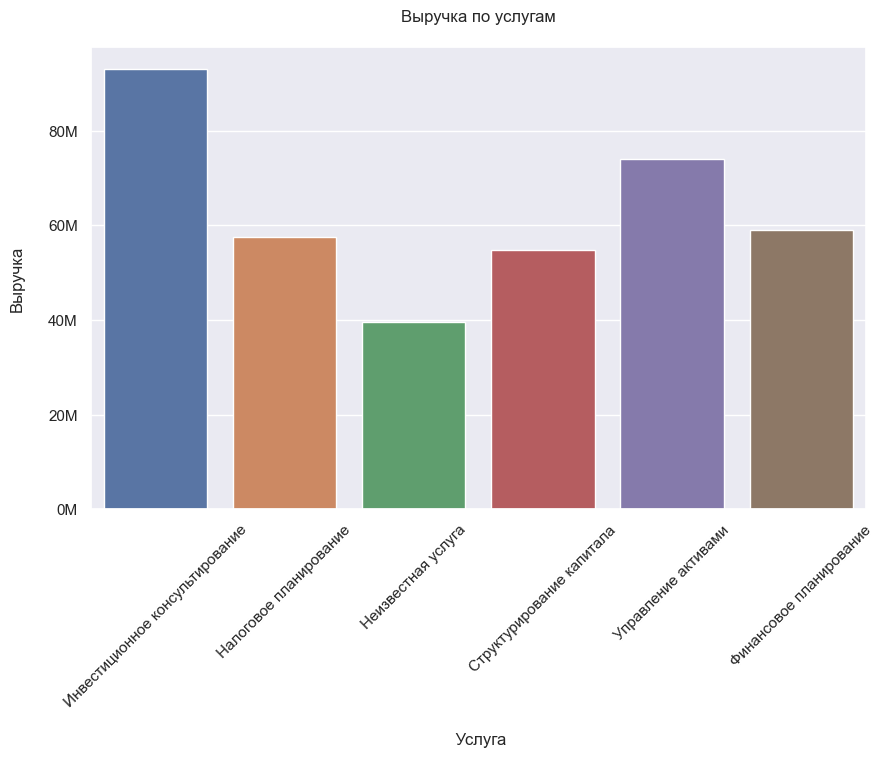

In [61]:
sns.barplot(amount_by_service, x='service', y='amount', hue='service')
plt.xticks(rotation=45)
plt.title("Выручка по услугам\n")
plt.xlabel("\n Услуга")
plt.ylabel("Выручка\n")

def format_ticks(value, _):
    return f"{value / 1_000_000:.0f}M"
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.show()

***3. Построим диаграмму зависимости средней суммы транзакции от возрастных групп***

In [62]:
clients_transactions.age.describe() # найдем минимальные и максимальные значения возраста

count    6817.000000
mean       40.055303
std        11.861635
min        20.000000
25%        30.000000
50%        40.000000
75%        50.000000
max        60.000000
Name: age, dtype: float64

In [63]:
bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, np.inf] # создадим корзины возраста через каждые 5 лет
labels = ['20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60+']

In [64]:
clients_transactions['age_group'] = pd.cut(clients_transactions.age, bins=bins, labels=labels, right=False) # добавим колонку с корзинами к датафрейму

In [65]:
clients_transactions.head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,date,age,gender,net_worth,client_capital_lvl,age_group
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller,2025-01-04,41.0,Мужчина,2514729.46,high_capital,40-44
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard,2025-03-10,28.0,Мужчина,566568.29,medium_capital,25-29
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer,2025-02-13,55.0,Женщина,1896001.28,high_capital,55-59
3,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena,2025-03-18,31.0,Мужчина,4865849.92,high_capital,30-34
4,822d5795-4f08-4a7a-9692-7f5863945bdf,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,2025-02-21 21:50:30,Инвестиционное консультирование,85575.773285,Кредитная карта,West Jaymouth,Harold Gibson,2025-02-21,59.0,Женщина,3992281.84,high_capital,55-59


In [66]:
amount_by_age_group = clients_transactions.groupby('age_group', as_index=False, observed=False).amount.mean().round() # посчитаем среднию выручку по возрастным группам
amount_by_age_group

,age_group,amount
0,20-24,48459.0
1,25-29,48399.0
2,30-34,50225.0
3,35-39,48144.0
4,40-44,49890.0
5,45-49,52320.0
6,50-54,49996.0
7,55-59,49440.0
8,60+,50844.0


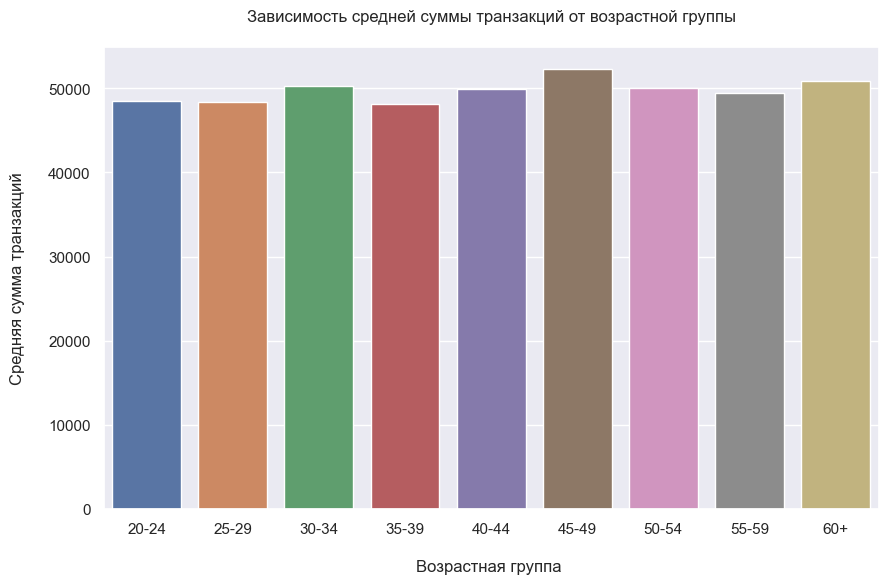

In [67]:
sns.barplot(amount_by_age_group, x='age_group', y='amount', hue='age_group')
plt.title("Зависимость средней суммы транзакций от возрастной группы\n")
plt.xlabel("\nВозрастная группа ")
plt.ylabel("Средняя cумма транзакций\n")
plt.show()

***Ответ: средняя выручка по возрастным группам примерно одинакова, наибольшая выручка наблюдается для группы 45-49 лет.***

***Вывод по главе: был построен график распределения сумм транзакций, диаграмма выручки по услугам, диаграмма зависимости средней суммы транзакции от возрастной группы***

## 5. Прогнозирование спроса на следующий месяц

***1. Подготовим данные***

In [68]:
transactions_df.head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant,date
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller,2025-01-04
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard,2025-03-10
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer,2025-02-13
4,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena,2025-03-18
5,822d5795-4f08-4a7a-9692-7f5863945bdf,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,2025-02-21 21:50:30,Инвестиционное консультирование,85575.773285,Кредитная карта,West Jaymouth,Harold Gibson,2025-02-21


In [69]:
transactions_df = transactions_df.sort_values('transaction_date') # отсортируем по датам
transactions_df.dtypes

transaction_id              object
client_id                   object
transaction_date    datetime64[ns]
service                     object
amount                     float64
payment_method              object
city                        object
consultant                  object
date                datetime64[ns]
dtype: object

***2. Посчитаем выручку за каждый день***

In [70]:
amount_by_day = transactions_df.query("date != date.max() & date != date.min()").groupby('date').amount.sum().reset_index()# уберем из данных первый и последний день т.к. они могут не включать 24 часа
amount_by_day['day_num'] = range(len(amount_by_day)) # добавим порядковый номер дня
amount_by_day.head()

,date,amount,day_num
0,2025-01-02,5.162097e+06,0
1,2025-01-03,6.658985e+06,1
2,2025-01-04,5.850844e+06,2
3,2025-01-05,5.041346e+06,3
4,2025-01-06,5.366167e+06,4


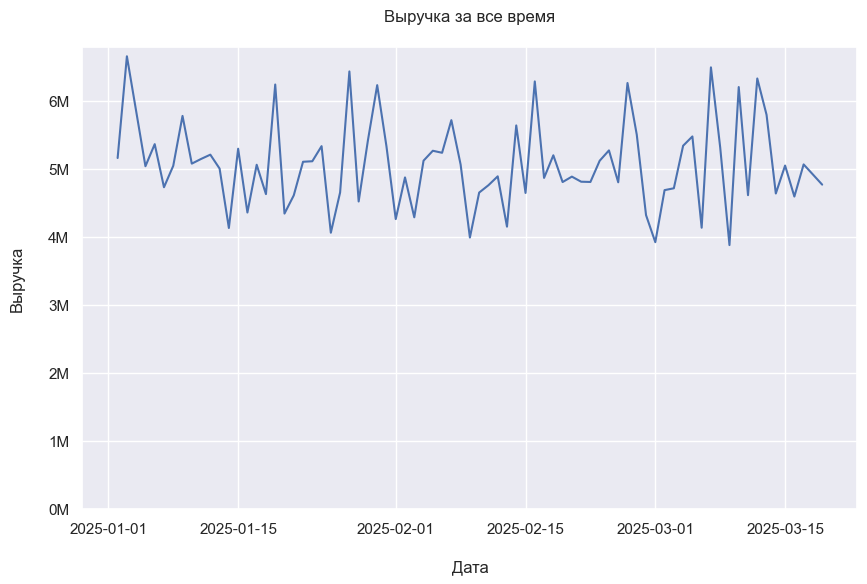

In [71]:
sns.lineplot(amount_by_day, x='date', y='amount')
plt.ylim(0, None)

plt.title("Выручка за все время\n")
plt.xlabel("\nДата")
plt.ylabel("Выручка\n")

def format_ticks(value, _):
    return f"{value / 1_000_000:.0f}M"
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.show()

***3. Сделаем прогноз выручки на следующий месяц***

In [72]:
amount_by_day.head()

,date,amount,day_num
0,2025-01-02,5.162097e+06,0
1,2025-01-03,6.658985e+06,1
2,2025-01-04,5.850844e+06,2
3,2025-01-05,5.041346e+06,3
4,2025-01-06,5.366167e+06,4


In [73]:
X = sm.add_constant(amount_by_day["day_num"])
y = amount_by_day["amount"]
model = sm.OLS(y, X).fit() # фитим модель

In [74]:
predictions = model.get_prediction(X)
pred_df = predictions.summary_frame(alpha=0.05)  # 95% доверительный интервал
amount_by_day[["predicted", "ci_lower", "ci_upper"]] = pred_df[["mean", "mean_ci_lower", "mean_ci_upper"]] # добавляем колонки доверительного интервала

In [75]:
amount_by_day

,date,amount,day_num,predicted,ci_lower,ci_upper
0,2025-01-02,5.162097e+06,0,5.143067e+06,4.851723e+06,5.434411e+06
1,2025-01-03,6.658985e+06,1,5.141197e+06,4.855546e+06,5.426848e+06
2,2025-01-04,5.850844e+06,2,5.139327e+06,4.859329e+06,5.419325e+06
3,2025-01-05,5.041346e+06,3,5.137457e+06,4.863068e+06,5.411846e+06
4,2025-01-06,5.366167e+06,4,5.135586e+06,4.866761e+06,5.404412e+06
...,...,...,...,...,...,...
72,2025-03-15,5.051346e+06,72,5.008412e+06,4.739586e+06,5.277238e+06
73,2025-03-16,4.595248e+06,73,5.006542e+06,4.732153e+06,5.280931e+06
74,2025-03-17,5.068013e+06,74,5.004671e+06,4.724673e+06,5.284670e+06
75,2025-03-18,4.919870e+06,75,5.002801e+06,4.717150e+06,5.288452e+06


In [76]:
future_dates = pd.date_range(start=amount_by_day['date'].max() + pd.Timedelta(days=1), periods=30, freq='D') 
future_days = (future_dates - amount_by_day['date'].min()).days.values.reshape(-1, 1) # вычисляем порядковые номера дня след. месяца

In [77]:
future_X = sm.add_constant(future_days) 
future_pred = model.get_prediction(future_X)
future_pred_df = future_pred.summary_frame(alpha=0.05)
future_df = pd.DataFrame({
    "date": future_dates,
    "predicted": future_pred_df["mean"],
    "ci_lower": future_pred_df["mean_ci_lower"],
    "ci_upper": future_pred_df["mean_ci_upper"]
}) # считаем прогнозируемую прибыль следующего месяца

In [78]:
future_df.head()

,date,predicted,ci_lower,ci_upper
0,2025-03-20,4.999061e+06,4.701986e+06,5.296136e+06
1,2025-03-21,4.997191e+06,4.694348e+06,5.300033e+06
2,2025-03-22,4.995320e+06,4.686676e+06,5.303965e+06
3,2025-03-23,4.993450e+06,4.678972e+06,5.307928e+06
4,2025-03-24,4.991580e+06,4.671237e+06,5.311923e+06


***4. Строим объединенный график текущей и прогнозируемой прибыли с добавлением доверительного интервала***

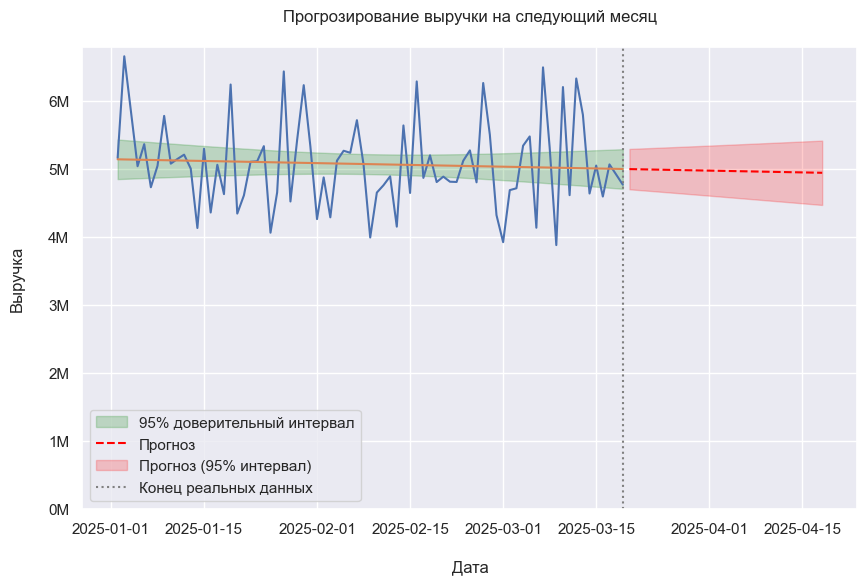

In [79]:
sns.lineplot(amount_by_day, x='date', y='amount')
sns.lineplot(amount_by_day, x='date', y='predicted')

plt.fill_between(amount_by_day["date"], amount_by_day["ci_lower"], amount_by_day["ci_upper"],
    color="green", alpha=0.2, label="95% доверительный интервал")

sns.lineplot(future_df, x='date', y='predicted', color="red", linestyle="--", label="Прогноз")
plt.fill_between(
    future_df["date"], future_df["ci_lower"], future_df["ci_upper"],
    color="red", alpha=0.2, label="Прогноз (95% интервал)"
)

plt.title("Прогрозирование выручки на следующий месяц\n")
plt.xlabel("\nДата")
plt.ylabel("Выручка\n")

def format_ticks(value, _):
    return f"{value / 1_000_000:.0f}M"
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

last_real_date = amount_by_day["date"].max()
plt.axvline(x=last_real_date, color="gray", linestyle=":", label="Конец реальных данных")
plt.legend()
plt.ylim(0, None)
plt.show()

***Вывод: был проделан регрессионый линейный прогноз выручки. Виден тренд на медленное снижение прибыли с течением времени***